In [2]:
# importing all the libraries we need
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import random
import torch
from torch import cuda,optim
from torchvision import models,transforms,datasets
import torch.nn as nn
from torch.utils.data import random_split,DataLoader,sampler
from sklearn.metrics import recall_score,precision_score,f1_score,confusion_matrix,classification_report
from PIL import Image

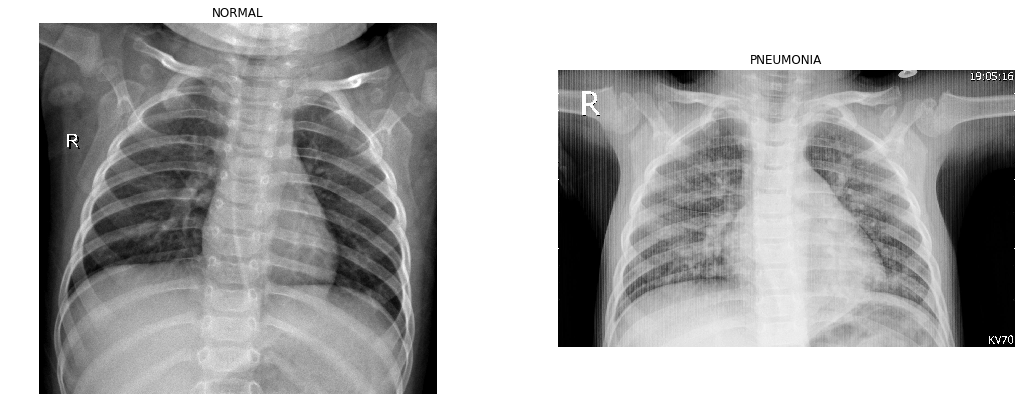

In [3]:
data_dir = './chest_xray/'
samples = {}
for i in range(1):
    for folder in os.listdir(data_dir+'train'):
        samples[folder]=(os.path.join(data_dir+'train/'+folder+"/",random.choice(os.listdir(data_dir+'train/'+folder+'/'))))
        
plt.figure(figsize=(18,15))
for i,s in enumerate(samples):
    plt.subplot(2,2,i+1)
    plt.imshow(Image.open(samples[s]),cmap='gray')
    plt.title(s)
    plt.axis('off')

In [4]:
# loading the model architecture
model = models.vgg16(pretrained=True)
# print(model)

# freezing all the parameters from training
for param in model.parameters():
    param.requires_grad = False
    
num_classes = 2
model.classifier[-1] = nn.Sequential(nn.Linear(in_features=model.classifier[-1].in_features,out_features=1024),
                                     nn.ReLU(),
#                                      nn.Dropout(0.4),
                                     nn.Linear(in_features=1024,out_features=1024),
                                     nn.ReLU(),
                                     nn.Dropout(0.4),
                                     nn.Linear(in_features=1024,out_features=2),
                                     nn.LogSoftmax(dim=1))
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
# doing data augmentation 
target_shape = (224,224)
train_transform = transforms.Compose([transforms.Resize(target_shape),
                                      transforms.RandomRotation(45),transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
#                                      transforms.Grayscale(), 
                                      transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],
                                                                                [0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize(target_shape),
#                                     transforms.RandomRotation(45),transforms.RandomVerticalFlip(),
#                                     transforms.RandomHorizontalFlip(),
#                                     transforms.Grayscale(),
                                    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],
                                                                                [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(target_shape),
#                                      transforms.Grayscale(),
                                     transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],
                                                                                [0.229, 0.224, 0.225])])

In [6]:
train_data = datasets.ImageFolder(data_dir+"train",transform=train_transform)
val_data = datasets.ImageFolder(data_dir+'test',transform=val_transform)
test_data = datasets.ImageFolder(data_dir+"val",transform=test_transform)

# # splitting the data into train/validation sets
# train_len = int(len(train_val_data)*0.8)
# val_len = int(len(train_val_data) - train_len)
# train_data,val_data = random_split(train_val_data,[train_len,val_len])

print("train len: ",len(train_data),"\nval len: ",len(val_data),"\ntest len: ",len(test_data))

train len:  5216 
val len:  624 
test len:  16


In [7]:
# loading the data into data loader
batch_size = 16
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [8]:
#check whether we can use the gpu or not
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)
model.to(device)

# the loss function and optimizer
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

cuda:0


In [9]:
def train(model,criterion,optimizer,num_epochs=10):
    start = time.time()
#     best_model = model.state_dict()
#     best_acc = 0.0
    loss_over_time_train = []
    loss_over_time_val = []
    acc_over_time_train = []
    acc_over_time_val = []
    
    for epoch in range(num_epochs):
        print("{}/{} epoch".format(epoch+1,epochs))
        
        # each epoch has a training and validation phase
        for phase in ['train','valid']:
            if phase == 'train':
                model.train()             # set the model to train mode
                dataLoader = train_loader
            else:
                model.eval()             # set the model to evaluate mode
                dataLoader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over the data
            for data in dataLoader:
                # get the inputs
                inputs, labels = data

                inputs=inputs.to(device)
                labels=labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs,labels)

                # backward + optimize only if in training phase
#                     if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # calculating the loss and accuracy
                running_loss  += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == "train":
                epoch_loss = running_loss / len(train_data)
                loss_over_time_train.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(train_data)
                acc_over_time_train.append(epoch_acc) 
            else:
                epoch_loss = running_loss / len(val_data)
                loss_over_time_val.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(val_data)
                acc_over_time_val.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))
            

#             if phase == 'valid' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model =model.state_dict()
            
        print('-' * 60)
                    
    total_time = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        total_time // 60, total_time % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
#     model.load_state_dict(best_model)
    loss = {"train":loss_over_time_train,"val":loss_over_time_val}
    acc = {"train":acc_over_time_train,"val":acc_over_time_val}
    return model,loss,acc

In [20]:
# training the model
# i trained for 20 epochs then another 30 epochs for total of 50 epochs
epochs = 30
trained_model,loss,acc = train(model,criterion,optimizer,num_epochs=epochs)

1/30 epoch
train Loss: 0.2013 Acc: 0.9176
valid Loss: 0.3450 Acc: 0.8542
------------------------------------------------------------
2/30 epoch
train Loss: 0.2011 Acc: 0.9178
valid Loss: 0.3504 Acc: 0.8622
------------------------------------------------------------
3/30 epoch
train Loss: 0.1960 Acc: 0.9204
valid Loss: 0.3745 Acc: 0.8269
------------------------------------------------------------
4/30 epoch
train Loss: 0.1965 Acc: 0.9183
valid Loss: 0.3340 Acc: 0.8542
------------------------------------------------------------
5/30 epoch
train Loss: 0.2062 Acc: 0.9183
valid Loss: 0.3272 Acc: 0.8654
------------------------------------------------------------
6/30 epoch
train Loss: 0.1978 Acc: 0.9170
valid Loss: 0.3269 Acc: 0.8606
------------------------------------------------------------
7/30 epoch
train Loss: 0.1921 Acc: 0.9214
valid Loss: 0.3315 Acc: 0.8654
------------------------------------------------------------
8/30 epoch
train Loss: 0.1886 Acc: 0.9268
valid Loss: 0.3113 A

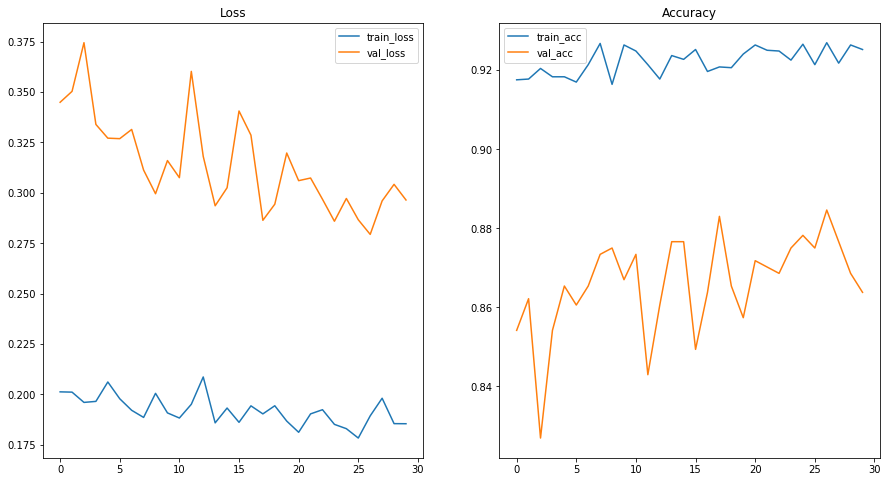

In [21]:
# plotting the loss and accuracy curve for each phase
train_loss = loss['train']
val_loss = loss['val']
train_acc = acc['train']
val_acc = acc['val']

epochs_range = range(epochs)
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(epochs_range,train_loss,label='train_loss')
plt.plot(epochs_range,val_loss,label='val_loss')
plt.legend(loc=0)
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range,train_acc,label='train_acc')
plt.plot(epochs_range,val_acc,label='val_acc')
plt.legend(loc=0)
plt.title('Accuracy')

plt.show()

In [13]:
# testing how good the model is
def testing(model,criterion):
    
    model.eval()       # setting the model to evaluate mode
    test_loss = 0.0
    test_acc = 0.0
#     ruunning_corrects = 0.0
    preds = []
    with torch.no_grad():
        for inputs,labels in test_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            # predicting
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            _,pred = torch.max(outputs,dim=1)
            preds.append(pred)

            # calculating the loss and accuracy 
            test_loss += loss.item()*inputs.size(0)
#             ruunning_corrects += torch.sum(pred == labels.data)
#             acc = ruunning_corrects.double() / len(test_data)
            correct = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct.type(torch.FloatTensor))
            test_acc += accuracy.item() * inputs.size(0)
    
    # avreging the loss and accuracy
    test_loss = test_loss/len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)
        
    print("test loss: {:.4f}  test acc: {:.4f}".format(test_loss,test_acc))
    return preds

In [22]:
# testing the model
pred = testing(model,criterion)

test loss: 0.2305  test acc: 0.9375


In [23]:
# preparing the preds and labels for measurments metrics
labels = test_loader.dataset.targets

preds = []
for tensor in pred:
    preds.append(tensor.tolist())

p = []
for batch in preds:
    for pe in batch:
        p.append(pe)

In [24]:
print(labels)
print(p)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]


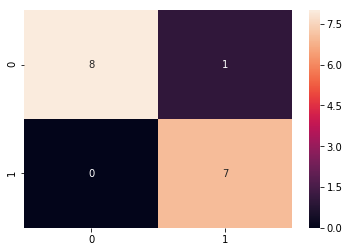

In [25]:
# ploting confusion matrix
import seaborn
cm = confusion_matrix(p,labels)
seaborn.heatmap(cm,annot=True)

In [26]:
print('precision: {:.3f} \nrecall: {:.3f} \nf1_score: {:.3f}'.format(precision_score(np.array(labels),np.array(p)),
                                                                     recall_score(np.array(labels),np.array(p)),
                                                                     f1_score(np.array(labels),np.array(p))))

precision: 1.000 
recall: 0.875 
f1_score: 0.933


tensor([[-0.6341, -0.7559]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


(-0.5, 799.5, 914.5, -0.5)

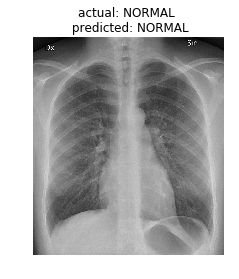

In [27]:
# predicting an image from the web
from urllib import request
img_url = './chest_xray/download1.jpg'
# img_url = 'https://upload.wikimedia.org/wikipedia/commons/a/a1/Normal_posteroanterior_%28PA%29_chest_radiograph_%28X-ray%29.jpg'
image = Image.open(img_url).convert(mode='RGB')
# image = Image.open(request.urlopen(img_url)).convert(mode='RGB')
trans = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
img = trans(image)
img = img.to(device)
img = img.unsqueeze(0)
classes_ = ['NORMAL','PNEUMONIA']
model.eval()
outputs = model(img)
print(outputs)
_,pred = torch.max(outputs,dim=1)
prediction = classes_[pred]
plt.imshow(image)
plt.title(f"actual: NORMAL \n predicted: {prediction}")
plt.axis('off')